In [1]:
from sklearn.datasets import make_classification
import scipy 
import matplotlib.pyplot as pl
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, \
                            auc,\
                            f1_score, \
                            recall_score, \
                            precision_score, \
                            classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

import sys
sys.path.append("../src")
from utils import prepare_U_L_data, \
                  self_trainer, \
                  data_sampler, \
                  evaluate_model

In [2]:
train_vec = scipy.sparse.load_npz("../../data/train_vec.npz")
test_vec = scipy.sparse.load_npz("../../data/test_vec.npz")
y_train = np.load("../../data/y_train.npz")['arr_0']
y_test = np.load("../../data/y_test.npz")['arr_0']

In [3]:
cl = SGDClassifier(loss='log', n_jobs=-1) # for self-training prob. is needed

In [4]:
indices = np.where(y_train != -1)[0]
train_L = train_vec[y_train != -1]
y_train_L = y_train[y_train != -1]

In [5]:
a = train_vec[[0,1,2]]
b = train_vec[[5,4,7,5,6,7,5]]
a.shape, b.shape

((3, 1021333), (7, 1021333))

In [6]:
scipy.sparse.vstack([a,b]).shape

(10, 1021333)

In [7]:
cl.fit(train_L, y_train_L)

SGDClassifier(loss='log', n_jobs=-1)

In [8]:
y_train_predict = cl.predict(train_L)
y_test_predict = cl.predict(test_vec)

In [9]:
print(classification_report(y_train_L, y_train_predict))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2865
           1       0.99      0.99      0.99      2804

    accuracy                           0.99      5669
   macro avg       0.99      0.99      0.99      5669
weighted avg       0.99      0.99      0.99      5669



In [10]:
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      3748
           1       0.84      0.89      0.86      3752

    accuracy                           0.86      7500
   macro avg       0.86      0.86      0.86      7500
weighted avg       0.86      0.86      0.86      7500



In [11]:
sgd = SGDClassifier(loss='log', n_jobs=-1)
cl_self = SelfTrainingClassifier(sgd, threshold=0.95)

In [12]:
cl_self.fit(train_vec, y_train)

SelfTrainingClassifier(base_estimator=SGDClassifier(loss='log', n_jobs=-1),
                       threshold=0.95)

In [13]:
train = [train_vec, y_train]
test = [test_vec, y_test]
roc_scores = {}
roc_stds = {}
for i, l_frac in enumerate(np.linspace(0.05, 0.1, 10)):
    print(f"running for {l_frac:.2}")
    print("==========\n")
    roc_scores[i] = []
    roc_stds[i] = []
    for u_frac in np.linspace(0.001, 0.5, 10):
        roc, roc_std = self_trainer(ml_trainer=cl_self, 
                           feature_cols='text',
                           target_col='review',
                           train=train,
                           test=test,
                           l_frac=l_frac, 
                           u_frac=u_frac, 
                           n_realization=10)
        roc_scores[i].append(roc)
        roc_stds[i].append(roc_std)

running for 0.05

running for 0.056

running for 0.061

running for 0.067

running for 0.072

running for 0.078

running for 0.083

running for 0.089

running for 0.094

running for 0.1



Labeled Num: 5669, Unlabeled: 8750


Text(0, 0.5, 'Ratio of ROC Improvement')

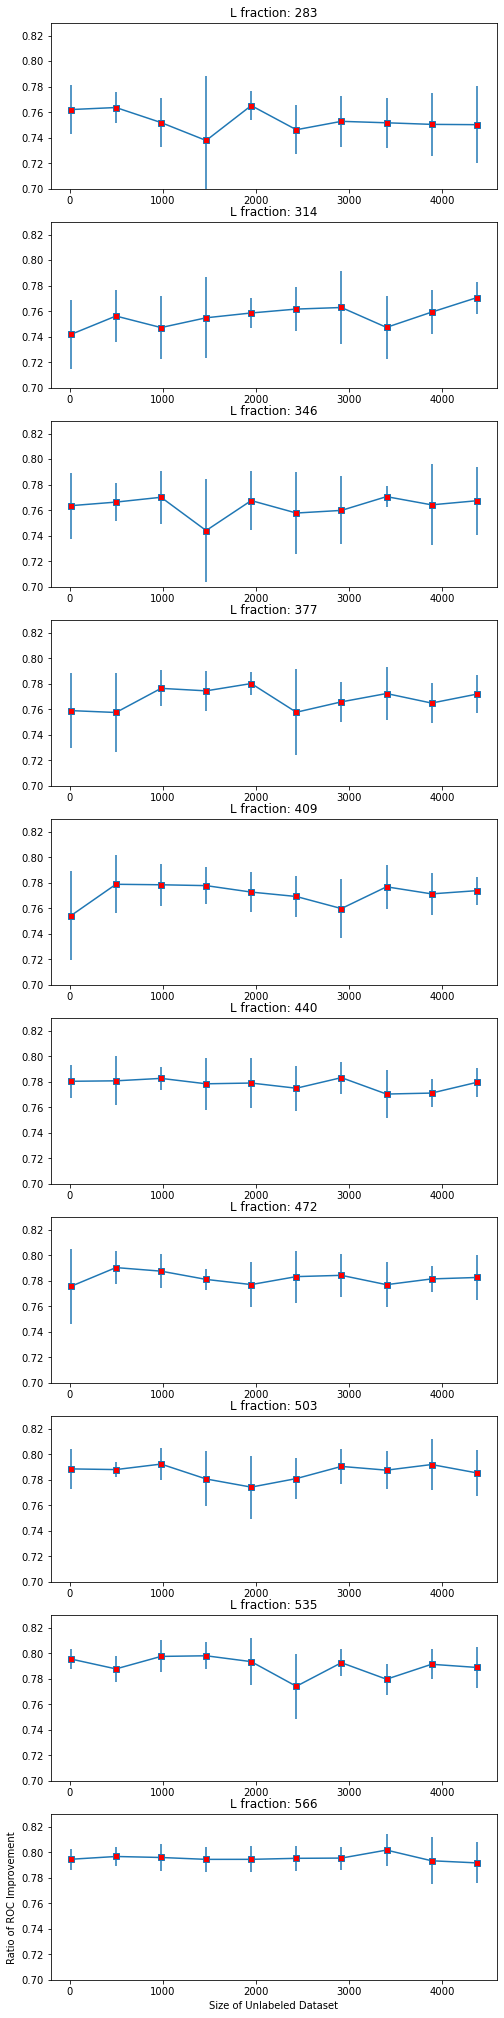

In [14]:
l_num, u_num = (y_train!=-1).sum(), (y_train==-1).sum()
print(f"Labeled Num: {l_num}, Unlabeled: {u_num}")
fig, ax = pl.subplots(10, 1, figsize=(8,36))
for i,k in zip(roc_scores.keys(), l_num*np.linspace(0.05, 0.1, 10)):
    l_roc = roc_scores[i][0]
    roc_ratio = (roc_scores[i] - l_roc)/l_roc
    ax[i].errorbar(u_num*np.linspace(0.001, 0.5, 10), roc_scores[i], roc_stds[i], 
                   marker='s', mfc='red')
    ax[i].set_title('L fraction: {:}'.format(int(k)))
    ax[i].set_ylim(0.7, 0.83)
pl.xlabel('Size of Unlabeled Dataset')
pl.ylabel('Ratio of ROC Improvement')